### Description: This script plots total and CG flash rates for the Edmond-Carney storm (Fig 3 (a) and (b)). NLDN data used with a threshold of 15 kA to avoid misclassified IC flashes.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import num2date, date2num, Dataset
import pyart
import glob
import os
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime

# set run command parameters for matplotlib plots
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)


plt.rcParams["figure.figsize"] = [20, 8]
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 23
plt.rcParams["ytick.labelsize"] = 23
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 18
plt.rcParams["legend.markerscale"] = 2


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### First step is to create a dataframe for NLDN data and perform basic pre-processing steps to obtain filtered/reduced dataset

In [2]:
file = os.path.expanduser(
    '../data/interim/051913_NLDN_15kA_filter.txt')

# Load NLDN data as a pandas dataframe and add column labels
data = pd.read_csv(file, delim_whitespace=True, header=None, names=[
                   "date", "time", "lat", "lon", "unknown", "Power", "kA", "strokes"])

# Add two columns to create a new 'datetime' column 
# that contains entire datetime as string
data['datetime'] = data['date'] + ' ' + data['time']

# Assign 'datetime' column in the dataframe as the index 
data.index = data['datetime']

# convert datetime strings to datetime objects and drop irrelevant columns from the dataframe
data.index = pd.to_datetime(data['datetime']) 
data = data.drop(columns=['date', 'time', 'datetime'])

# filter out all NLDN flashes with power between -15 and 15 kA and time of occurrence between 2000 and 2230 UTC on May  19, 2013 
df2 = data[~((data['Power'] > -15) & (data['Power'] < 15))]
df3 = df2['2013-05-19 20:00:00':'2013-05-19 22:30:00']
df3


,lat,lon,unknown,Power,kA,strokes
datetime,,,,,,
2013-05-19 20:00:01,43.109,-92.876,69.6,16.1,kA,1
2013-05-19 20:00:01,22.778,-82.032,-385.4,-61.7,kA,1
2013-05-19 20:00:03,35.456,-83.116,-188.3,-28.0,kA,1
2013-05-19 20:00:04,21.869,-79.845,-364.3,-58.1,kA,5
2013-05-19 20:00:04,38.671,-81.404,-115.8,-15.6,kA,1
...,...,...,...,...,...,...
2013-05-19 22:29:59,35.279,-74.943,-178.9,-26.4,kA,2
2013-05-19 22:29:59,38.592,-96.367,-112.9,-15.1,kA,1
2013-05-19 22:29:59,37.624,-98.412,-126.3,-17.4,kA,1


### The Edmond-Carney storm was moving NE with time, and there were additional isolated storms on that day. Therefore, it is necessary to account for only those CG flases which were within physically plausible range from the storm.

In [3]:
# We accounted for storm motion using 10 minute OKLMA files. The bounding box extent of all flash activity within 
# the storm was manually noted. Subsequently, one dataframe was created for each 10 minute interval from
# 2000 to 2230 UTC to isolate NLDN flashes within storm's bounding region. 

# dataframes have been randomly named and later combined into a single dataframe 
one_p = df3['2013-05-19 20:00:00':'2013-05-19 20:09:59']
one_p_ = one_p[((one_p['lon'] > -98.1) & (one_p['lon'] < -97.6)
                & (one_p['lat'] > 35.35) & (one_p['lat'] < 35.8))]

one_q = df3['2013-05-19 20:10:00':'2013-05-19 20:19:59']
one_q_ = one_q[((one_q['lon'] > -98) & (one_q['lon'] < -97.3) &
                (one_q['lat'] > 35.35) & (one_q['lat'] < 35.8))]

one_r = df3['2013-05-19 20:20:00':'2013-05-19 20:29:59']
one_r_ = one_r[((one_r['lon'] > -98) & (one_r['lon'] < -97.3) &
                (one_r['lat'] > 35.35) & (one_r['lat'] < 35.8))]

one = df3['2013-05-19 20:30:00':'2013-05-19 20:39:59']
one_ = one[((one['lon'] > -97.9) & (one['lon'] < -97.2)
            & (one['lat'] > 35.4) & (one['lat'] < 35.9))]

two = df3['2013-05-19 20:40:00':'2013-05-19 20:49:59']
two_ = two[((two['lon'] > -97.8) & (two['lon'] < -97.1)
            & (two['lat'] > 35.45) & (two['lat'] < 36))]

three = df3['2013-05-19 20:50:00':'2013-05-19 20:59:59']
three_ = three[((three['lon'] > -97.75) & (three['lon'] < -97.1)
                & (three['lat'] > 35.45) & (three['lat'] < 36))]

four = df3['2013-05-19 21:00:00':'2013-05-19 21:09:59']
four_ = four[((four['lon'] > -97.8) & (four['lon'] < -97.1)
              & (four['lat'] > 35.4) & (four['lat'] < 36))]

five = df3['2013-05-19 21:10:00':'2013-05-19 21:19:59']
five_ = five[((five['lon'] > -97.7) & (five['lon'] < -96.8)
              & (five['lat'] > 35.5) & (five['lat'] < 36))]

six = df3['2013-05-19 21:20:00':'2013-05-19 21:29:59']
six_ = six[((six['lon'] > -97.6) & (six['lon'] < -96.8)
            & (six['lat'] > 35.5) & (six['lat'] < 36))]

seven = df3['2013-05-19 21:30:00':'2013-05-19 21:39:59']
seven_ = seven[((seven['lon'] > -97.6) & (seven['lon'] < -96.8)
                & (seven['lat'] > 35.5) & (seven['lat'] < 36.1))]

eight = df3['2013-05-19 21:40:00':'2013-05-19 21:49:59']
eight_ = eight[((eight['lon'] > -97.5) & (eight['lon'] < -96.6)
                & (eight['lat'] > 35.5) & (eight['lat'] < 36.2))]

nine = df3['2013-05-19 21:50:00':'2013-05-19 21:59:59']
nine_ = nine[((nine['lon'] > -97.4) & (nine['lon'] < -96.6) &
              (nine['lat'] > 35.55) & (nine['lat'] < 36.1))]

ten = df3['2013-05-19 22:00:00':'2013-05-19 22:09:59']
ten_ = ten[((ten['lon'] > -97.15) & (ten['lon'] < -96.6)
            & (ten['lat'] > 35.62) & (ten['lat'] < 36.1))]

eleven = df3['2013-05-19 22:10:00':'2013-05-19 22:19:59']
eleven_ = eleven[((eleven['lon'] > -97.25) & (eleven['lon'] < -96.75)
                  & (eleven['lat'] > 35.63) & (eleven['lat'] < 36.1))]

twelve = df3['2013-05-19 22:20:00':'2013-05-19 22:29:59']
twelve_ = twelve[((twelve['lon'] > -97) & (twelve['lon'] < -96.5)
                  & (twelve['lat'] > 35.62) & (twelve['lat'] < 36.1))]

# individual dataframes are merged into a single dataframe
final_data = pd.concat([one_p_, one_q_, one_r_, one_, two_, three_,
                        four_, five_, six_, seven_, eight_, nine_, ten_, eleven_, twelve_])

### Next step is to aggregate all NLDN flashes in 1 min intervals to create histograms for CG flash frequency

In [4]:
# aggregate CG flashes by seconds
total = final_data.index.value_counts().sort_index()

# binning the aggregated CG counts above into 1 minute bins for calculatinf flash rates (CG/min)
total1 = total.resample("Min").agg({'sum'})

# filter out and aggregate positive and negative CG flashes into two variables
positive = final_data[(final_data['Power'] > 0)]
pos = positive.index.value_counts().sort_index()
pos1 = pos.resample("Min").agg({'sum'})

negative = final_data[(final_data['Power'] < 0)]
neg = negative.index.value_counts().sort_index()
neg1 = neg.resample("Min").agg({'sum'})

# create datetime stamps for missing timesteps and fill those indices with zero flash count
missing_idx = pd.date_range('2013-05-19 20:00:00',
                            '2013-05-19 22:30:00', freq='min')
total1 = total1.reindex(missing_idx, fill_value=0)
pos1 = pos1.reindex(missing_idx, fill_value=0)
neg1 = neg1.reindex(missing_idx, fill_value=0)

### We also want to plot the histogram for total lightning flash rates. After processing OKLMA dataset for the same duration (2000 - 2230 UTC) using lmatools python package, we saved results of flash rates calculation in the 'flash_stats.csv' file.

In [5]:
# Load data from lasso analysis generated flash stats csv file using lmatools
lasso = '../data/interim/flash_stats.csv'

lasso_data = pd.read_csv(lasso, usecols=[0, 2])
lasso_data = lasso_data[0:-1]
lasso_data.columns = ['time', 'number']

lasso_data.index = pd.to_datetime(lasso_data['time'])
lasso_data = lasso_data.drop(columns=['time'])

In [6]:
zdr_vol_ts = pd.read_csv('zdr_vol_gt_1dB_pyart_based_segmentation')
zdr_vol_ts = zdr_vol_ts.set_index('time')

In [7]:
zdr_vol_ts.index = pd.to_datetime(zdr_vol_ts.index)

In [8]:
zdr_vol_ts

,vol
time,
2013-05-19 20:02:36,90.625
2013-05-19 20:06:52,99.375
2013-05-19 20:11:07,195.875
2013-05-19 20:15:23,160.625
2013-05-19 20:19:38,223.750
2013-05-19 20:23:52,225.750
2013-05-19 20:28:09,266.000
2013-05-19 20:32:24,314.750
2013-05-19 20:36:40,234.750


### Final step is to plot the histograms of CG and total lightning flash rates using matplotlib

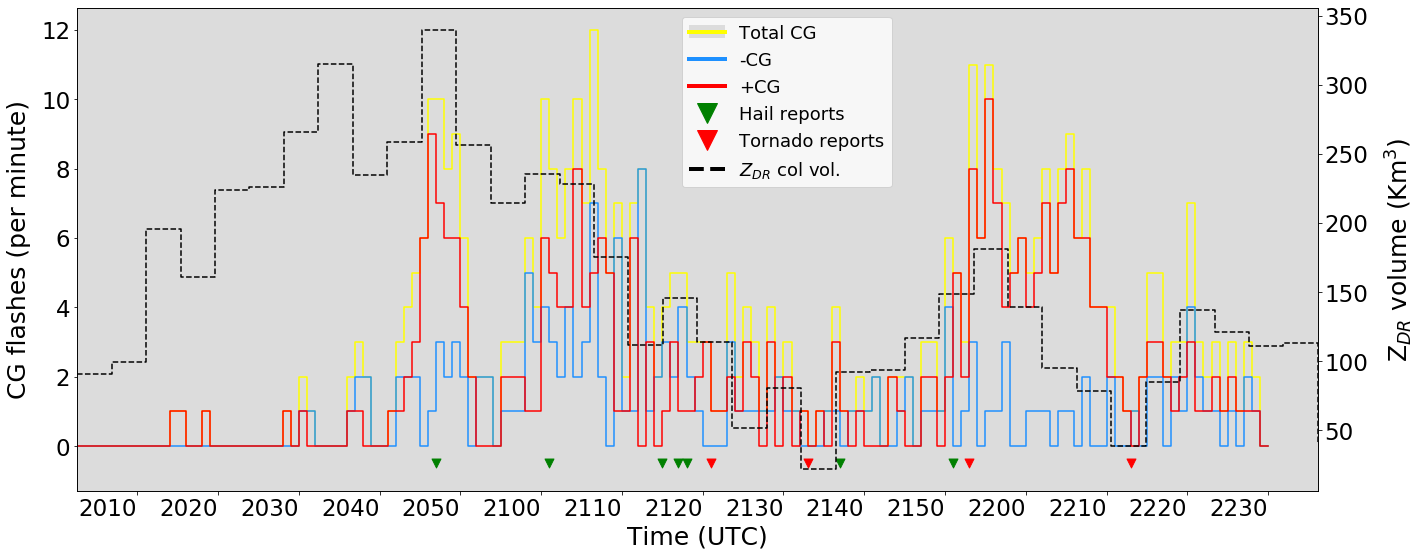

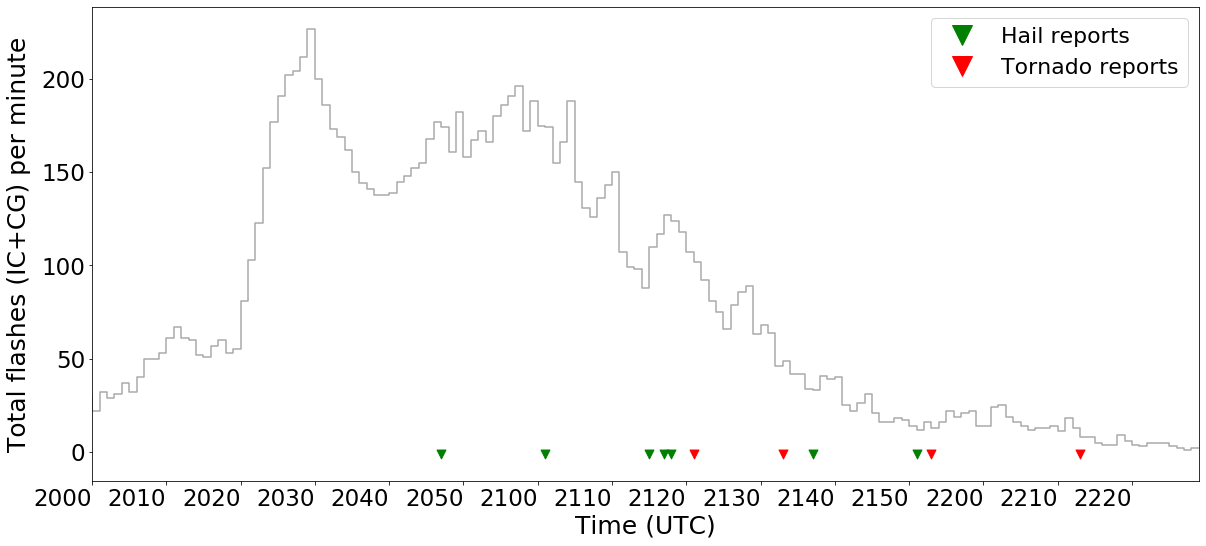

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(111)  # axis 1 for CG flash rates

ax1.set_facecolor('gainsboro')

with pd.plotting.plot_params.use('x_compat', True):
    total1.plot(drawstyle='steps', color='yellow',
                 ax=ax1, rot=0)
    neg1.plot(drawstyle='steps', color='dodgerblue',
              ax=ax1, rot=0)
    pos1.plot(drawstyle='steps', color='red', ax=ax1, rot=0)



# adjust and set the location of ticks and ticklabels
ax1.xaxis.set_major_locator(
    mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H%M'))
ax1.set_xlabel('Time (UTC)', fontsize=25)
ax1.set_ylabel('CG flashes (per minute)',
               rotation=90, labelpad=10, fontsize=25)

# add hail reports on x-axis (these reports were obtained from SPC storm reports archive)
ax1.scatter(datetime(2013, 5, 19, 20, 47, 0), -0.5,
            marker='v', s=80, c='g', label='Hail reports')
ax1.scatter(datetime(2013, 5, 19, 21, 1, 0), -0.5, marker='v', s=80, c='g')
ax1.scatter(datetime(2013, 5, 19, 21, 15, 0), -0.5, marker='v', s=80, c='g')
ax1.scatter(datetime(2013, 5, 19, 21, 17, 0), -0.5, marker='v', s=80, c='g')
ax1.scatter(datetime(2013, 5, 19, 21, 18, 0), -0.5, marker='v', s=80, c='g')
ax1.scatter(datetime(2013, 5, 19, 21, 37, 0), -0.5, marker='v', s=80, c='g')
ax1.scatter(datetime(2013, 5, 19, 21, 51, 0), -0.5, marker='v', s=80, c='g')

# add tornado reports on x-axis (these reports were obtained from SPC storm reports archive)
ax1.scatter(datetime(2013, 5, 19, 21, 21, 0), -0.5, marker='v', s=80, c='r')
ax1.scatter(datetime(2013, 5, 19, 21, 33, 0), -0.5, marker='v', s=80, c='r')
ax1.scatter(datetime(2013, 5, 19, 21, 53, 0), -0.5, marker='v', s=80, c='r')
ax1.scatter(datetime(2013, 5, 19, 22, 13, 0), -0.5, marker='v', s=80, c='r')

axt = ax1.twinx()
with pd.plotting.plot_params.use("x_compat", True):
    plot2 = zdr_vol_ts.sum(level="time").plot(
        drawstyle="steps-post", color="k", ax=axt, rot=0,
        linestyle = '--',legend=False,
    )  # step line plot for zdr volume in subplot 1

axt.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
axt.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
axt.set_ylabel("Z$_{DR}$ volume (Km$^{3}$)", labelpad=15, fontsize=25)

legend_elements = [Patch(facecolor='gainsboro', label='Total CG'), Line2D([0], [0], color='yellow', lw=4, label='total CG'),
                   Line2D([0], [0], color='dodgerblue', lw=4, label='-CG'),
                   Line2D([0], [0], color='red', lw=4, label='+CG'),
                   Line2D([0], [0], color='green', marker='v', linestyle='None',
                          markersize=10, label='Hail reports'),
                   Line2D([0], [0], color='red', marker='v', linestyle='None',
                          markersize=10, label='Tornado reports'),
                   Line2D([0], [0], color='k', lw=4, linestyle='--',label='$Z_{DR}$ col vol}')
                  ]

ax1.legend(((legend_elements[0], legend_elements[1]), legend_elements[2],
            legend_elements[3], legend_elements[4], legend_elements[5], legend_elements[6]),
           ('Total CG', '-CG', '+CG', 'Hail reports', 'Tornado reports','$Z_{DR}$ col vol.'),
           bbox_to_anchor=(0.48, 0.5, 0.5, 0.5), prop={'size': 18})

# fig.set_figheight(15)
# fig.set_figwidth(12.9)

plt.tight_layout()
plt.show()


# Figure to plot total flashes obtained from lasso analysis in a separate figure

fig = plt.figure(figsize=(17,8))
ax2 = fig.add_subplot(111)
with pd.plotting.plot_params.use('x_compat', True):
    lasso_data.plot(drawstyle='steps', color='darkgray', ax=ax2)

ax2.xaxis.set_major_locator(
    mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H%M'))
plt.xticks(rotation=0)

# add hail reports on x-axis (these reports were obtained from SPC storm reports archive)
ax2.scatter(datetime(2013, 5, 19, 20, 47, 0), -1, marker='v', s=80, c='g')
ax2.scatter(datetime(2013, 5, 19, 21, 1, 0), -1, marker='v', s=80, c='g')
ax2.scatter(datetime(2013, 5, 19, 21, 15, 0), -1, marker='v', s=80, c='g')
ax2.scatter(datetime(2013, 5, 19, 21, 17, 0), -1, marker='v', s=80, c='g')
ax2.scatter(datetime(2013, 5, 19, 21, 18, 0), -1, marker='v', s=80, c='g')
ax2.scatter(datetime(2013, 5, 19, 21, 37, 0), -1, marker='v', s=80, c='g')
ax2.scatter(datetime(2013, 5, 19, 21, 51, 0), -1, marker='v', s=80, c='g')

# add tornado reports on x-axis (these reports were obtained from SPC storm reports archive)
ax2.scatter(datetime(2013, 5, 19, 21, 21, 0), -1, marker='v', s=80, c='r')
ax2.scatter(datetime(2013, 5, 19, 21, 33, 0), -1, marker='v', s=80, c='r')
ax2.scatter(datetime(2013, 5, 19, 21, 53, 0), -1, marker='v', s=80, c='r')
ax2.scatter(datetime(2013, 5, 19, 22, 13, 0), -1, marker='v', s=80, c='r')

ax2.legend((legend_elements[4], legend_elements[5]),
           ('Hail reports', 'Tornado reports'),
           loc='best', prop={'size': 22})

ax2.set_xlabel('Time (UTC)', fontsize=25)
ax2.set_ylabel('Total flashes (IC+CG) per minute', labelpad=10, fontsize=25)

plt.tight_layout()
plt.show()

### EXTRA STUFF (based on review comments)

### > 1. Peak current vs flash rates plot (comment 73 from Reviewer 2)

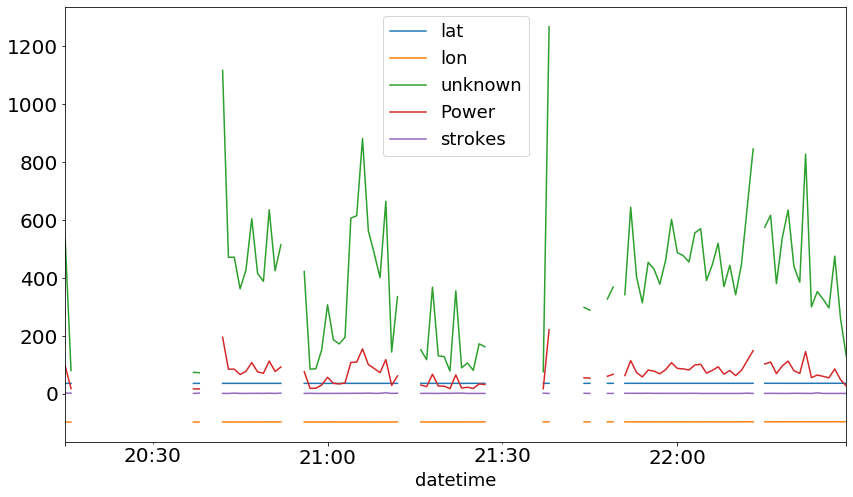

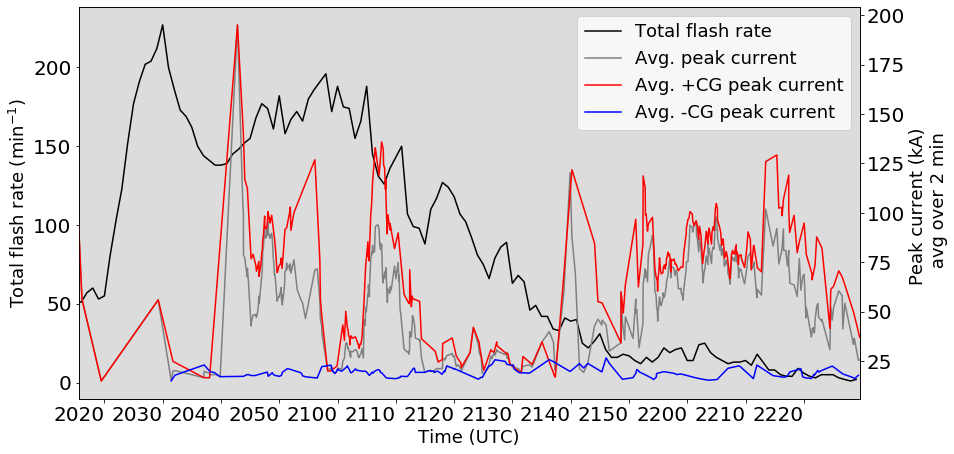

In [12]:
import pandas as pd

nldn_data = pd.read_csv('../data/interim/filtered_NLDN_15kA_only_within_EC_storm_for_pandas.txt')
nldn_data = nldn_data.set_index(pd.to_datetime(nldn_data['datetime']))
nldn_data = nldn_data.drop('datetime',axis=1)

nldn_data[nldn_data['Power'] > 0].resample('T').mean().plot()

file = os.path.expanduser(
    '../data/interim/051913_NLDN_15kA_filter.txt')

# Load NLDN data as a pandas dataframe and add column labels
data = pd.read_csv(file, delim_whitespace=True, header=None, names=[
                   "date", "time", "lat", "lon", "unknown", "Power", "kA", "strokes"])

# Add two columns to create a new 'datetime' column 
# that contains entire datetime as string
data['datetime'] = data['date'] + ' ' + data['time']

# Assign 'datetime' column in the dataframe as the index 
data.index = data['datetime']

# convert datetime strings to datetime objects and drop irrelevant columns from the dataframe
data.index = pd.to_datetime(data['datetime']) 
data = data.drop(columns=['date', 'time', 'datetime'])

# filter out all NLDN flashes with power between -15 and 15 kA and time of occurrence between 2000 and 2230 UTC on May  19, 2013 
df2 = data[~((data['Power'] > -15) & (data['Power'] < 15))]
df3 = df2['2013-05-19 20:00:00':'2013-05-19 22:30:00']
df3


# We accounted for storm motion using 10 minute OKLMA files. The bounding box extent of all flash activity within 
# the storm was manually noted. Subsequently, one dataframe was created for each 10 minute interval from
# 2000 to 2230 UTC to isolate NLDN flashes within storm's bounding region. 

# dataframes have been randomly named and later combined into a single dataframe 
one_p = df3['2013-05-19 20:00:00':'2013-05-19 20:09:59']
one_p_ = one_p[((one_p['lon'] > -98.1) & (one_p['lon'] < -97.6)
                & (one_p['lat'] > 35.35) & (one_p['lat'] < 35.8))]

one_q = df3['2013-05-19 20:10:00':'2013-05-19 20:19:59']
one_q_ = one_q[((one_q['lon'] > -98) & (one_q['lon'] < -97.3) &
                (one_q['lat'] > 35.35) & (one_q['lat'] < 35.8))]

one_r = df3['2013-05-19 20:20:00':'2013-05-19 20:29:59']
one_r_ = one_r[((one_r['lon'] > -98) & (one_r['lon'] < -97.3) &
                (one_r['lat'] > 35.35) & (one_r['lat'] < 35.8))]

one = df3['2013-05-19 20:30:00':'2013-05-19 20:39:59']
one_ = one[((one['lon'] > -97.9) & (one['lon'] < -97.2)
            & (one['lat'] > 35.4) & (one['lat'] < 35.9))]

two = df3['2013-05-19 20:40:00':'2013-05-19 20:49:59']
two_ = two[((two['lon'] > -97.8) & (two['lon'] < -97.1)
            & (two['lat'] > 35.45) & (two['lat'] < 36))]

three = df3['2013-05-19 20:50:00':'2013-05-19 20:59:59']
three_ = three[((three['lon'] > -97.75) & (three['lon'] < -97.1)
                & (three['lat'] > 35.45) & (three['lat'] < 36))]

four = df3['2013-05-19 21:00:00':'2013-05-19 21:09:59']
four_ = four[((four['lon'] > -97.8) & (four['lon'] < -97.1)
              & (four['lat'] > 35.4) & (four['lat'] < 36))]

five = df3['2013-05-19 21:10:00':'2013-05-19 21:19:59']
five_ = five[((five['lon'] > -97.7) & (five['lon'] < -96.8)
              & (five['lat'] > 35.5) & (five['lat'] < 36))]

six = df3['2013-05-19 21:20:00':'2013-05-19 21:29:59']
six_ = six[((six['lon'] > -97.6) & (six['lon'] < -96.8)
            & (six['lat'] > 35.5) & (six['lat'] < 36))]

seven = df3['2013-05-19 21:30:00':'2013-05-19 21:39:59']
seven_ = seven[((seven['lon'] > -97.6) & (seven['lon'] < -96.8)
                & (seven['lat'] > 35.5) & (seven['lat'] < 36.1))]

eight = df3['2013-05-19 21:40:00':'2013-05-19 21:49:59']
eight_ = eight[((eight['lon'] > -97.5) & (eight['lon'] < -96.6)
                & (eight['lat'] > 35.5) & (eight['lat'] < 36.2))]

nine = df3['2013-05-19 21:50:00':'2013-05-19 21:59:59']
nine_ = nine[((nine['lon'] > -97.4) & (nine['lon'] < -96.6) &
              (nine['lat'] > 35.55) & (nine['lat'] < 36.1))]

ten = df3['2013-05-19 22:00:00':'2013-05-19 22:09:59']
ten_ = ten[((ten['lon'] > -97.15) & (ten['lon'] < -96.6)
            & (ten['lat'] > 35.62) & (ten['lat'] < 36.1))]

eleven = df3['2013-05-19 22:10:00':'2013-05-19 22:19:59']
eleven_ = eleven[((eleven['lon'] > -97.25) & (eleven['lon'] < -96.75)
                  & (eleven['lat'] > 35.63) & (eleven['lat'] < 36.1))]

twelve = df3['2013-05-19 22:20:00':'2013-05-19 22:29:59']
twelve_ = twelve[((twelve['lon'] > -97) & (twelve['lon'] < -96.5)
                  & (twelve['lat'] > 35.62) & (twelve['lat'] < 36.1))]

# individual dataframes are merged into a single dataframe
final_data = pd.concat([one_p_, one_q_, one_r_, one_, two_, three_,
                        four_, five_, six_, seven_, eight_, nine_, ten_, eleven_, twelve_])

# aggregate CG flashes by seconds
total = final_data.index.value_counts().sort_index()

# binning the aggregated CG counts above into 1 minute bins for calculatinf flash rates (CG/min)
total1 = total.resample("Min").agg({'sum'})

# filter out and aggregate positive and negative CG flashes into two variables
positive = final_data[(final_data['Power'] > 0)]
pos = positive.index.value_counts().sort_index()
pos1 = pos.resample("Min").agg({'sum'})

negative = final_data[(final_data['Power'] < 0)]
neg = negative.index.value_counts().sort_index()
neg1 = neg.resample("Min").agg({'sum'})

# create datetime stamps for missing timesteps and fill those indices with zero flash count
missing_idx = pd.date_range('2013-05-19 20:00:00',
                            '2013-05-19 22:30:00', freq='min')
total1 = total1.reindex(missing_idx, fill_value=0)
pos1 = pos1.reindex(missing_idx, fill_value=0)
neg1 = neg1.reindex(missing_idx, fill_value=0)

# power_mean = final_data['Power'].resample("Min").mean()
# power_mean = power_mean.reindex(missing_idx,fill_value=0)

# power_max = final_data['Power'].resample("Min").max()
# power_max = power_max.reindex(missing_idx,fill_value=0)

# power_min = final_data['Power'].resample("Min").min()
# power_min = power_min.reindex(missing_idx,fill_value=0)

final_data['abs_power'] = np.abs(final_data['Power'])

power_rolling_mean_total = final_data.query('abs_power >= 15').rolling('2T').mean()['abs_power']

power_rolling_mean_pos_cg = final_data[final_data['Power'] > 15].rolling('2T').mean()['Power']
# final_data[final_data['Power'] > 15].resample("Min").mean()
power_rolling_mean_neg_cg = final_data[final_data['Power'] < -15].rolling('2T').mean()['Power']
power_rolling_mean_neg_cg = power_rolling_mean_neg_cg*-1
# final_data[final_data['Power'] < -15].resample("Min").mean()

# Load data from lasso analysis generated flash stats csv file using lmatools
lasso = '../data/interim/flash_stats.csv'

lasso_data = pd.read_csv(lasso, usecols=[0, 2])
lasso_data = lasso_data[0:-1]
lasso_data.columns = ['time', 'number']

lasso_data.index = pd.to_datetime(lasso_data['time'])
lasso_data = lasso_data.drop(columns=['time'])

lasso_data = lasso_data.rename(columns={'number':'Total flash rate'})

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(111)  # axis 1 for CG flash rates

ax1.set_facecolor('gainsboro')

with pd.plotting.plot_params.use('x_compat', True):
    lasso_data.plot( color='k',
                figsize=(14, 8), ax=ax1, rot=0,
                   label = 'Total flash rate',
                   legend=False)

ax2 = ax1.twinx()
with pd.plotting.plot_params.use('x_compat', True):
    c1 = power_rolling_mean_total.plot( color='gray',
                figsize=(14, 8), ax=ax2, rot=0,
                                 label = 'Avg. peak current ')
    
# with pd.plotting.plot_params.use('x_compat', True):
#     power_max[power_max > 0].plot( color='r',
#                 figsize=(12, 6), ax=ax2, rot=0)
    
# with pd.plotting.plot_params.use('x_compat', True):
#     power_max[power_max < 0].plot( color='r',
#                 figsize=(12, 6), ax=ax2, rot=0, linestyle='--')
    

# with pd.plotting.plot_params.use('x_compat', True):
#     power_min[power_min > 0].plot( color='b',
#                 figsize=(12, 6), ax=ax2, rot=0)
    
# with pd.plotting.plot_params.use('x_compat', True):
#     power_min[power_min < 0].plot( color='b',
#                 figsize=(12, 6), ax=ax2, rot=0, linestyle='--')
    
with pd.plotting.plot_params.use('x_compat', True):
    c2 = power_rolling_mean_pos_cg.plot( color='r',
                figsize=(14, 8), ax=ax2, rot=0,
                                  label = 'Avg. +CG peak current')
    

with pd.plotting.plot_params.use('x_compat', True):
    c3 = power_rolling_mean_neg_cg.plot( color='b',
                figsize=(14, 8), ax=ax2, rot=0,
                                  label = 'Avg. -CG peak current')

ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Total flash rate (min$^{-1}$)')
ax2.set_ylabel('Peak current (kA) \n avg over 2 min')

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
# plt.savefig('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/final_png_files/peak_current_flash_rates.png',dpi=300)
plt.show()